In [1]:
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from experimento import experimento
import pandas as pd
import seaborn as sns

## Experimentación con distintos solvers

In [ ]:
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp
from experimento import experimento
from collections import defaultdict

exec_time, n_iters, statuses = list(defaultdict(list) for i in range(3))

for i in ['CBC', 'SCIP', 'SAT', 'CP-SAT']:
    for j in range(50):
        solver = pywraplp.Solver.CreateSolver(i)

        s, t = experimento(solver, 4, 60, 3 * 60)

        exec_time[i].append(t)
        n_iters[i].append(solver.Iterations())
        statuses[i].append(s)

In [ ]:
import pickle

results = {'exec_time' : exec_time, 'n_iters' : n_iters, 'statuses' : statuses}
with open('..\Data\experimentos.pkl', 'wb') as file:
    pickle.dump(results, file)

In [ ]:
results

In [24]:
import pandas as pd
df = pd.DataFrame()
df['CBC'] = results['exec_time']['CBC']
df['SCIP'] = results['exec_time']['SCIP']
df['SAT'] = results['exec_time']['SAT']
df['CP-SAT'] = results['exec_time']['CP-SAT']

In [25]:
# df.to_csv('../Data/execTime_by_solver.csv', index = False)

## Comparación solvers

In [2]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pickle
from statsmodels.stats.multicomp import pairwise_tukeyhsd

with open('../Data/experimentos50ejec.pkl', 'rb') as file:
    res = pickle.load(file)

solvers, times = [], []

for k,v in res['exec_time'].items():
    solvers.extend([k]*len(v))
    times.extend(v)

df = pd.DataFrame()
df['solver'] = solvers
df['exec_time'] = times

A continuación hemos realizado una serie de pruebas con distintos solvers para averiguar cuál encuentra la solución óptima antes. Para agilizar las pruebas, hemos reducido el problema a 4 equipos y 60 días. Nuestro objetivo es determinar si existen diferencias significativas entre los tiempos de ejecución de cada solver.

El análisis de la varianza o ANOVA es una técnica estadística que nos permite averiguar si existen diferencias significativas entre distintas poblaciones. Aunque ANOVA fue nuestra primera elección, este modelo asume que las poblaciones a comparar son independientes, normales y de misma varianza. Por ello, debemos de comprobar que estos supuestos se cumplen antes de sacar conclusiones. (O) Como demostramos a continuación, el supuesto de normalidad no se cumple.

### Test de normalidad

Para comprobar si nuestras poblaciones son normales vamos a realizar el test de Shapiro Wilk, en el cual la hipótesis nula es que las poblaciones normales, mientras que la alternativa es lo contrario. Como el p-valor es menor a 0.05, rechazamos la hipótesis nula.

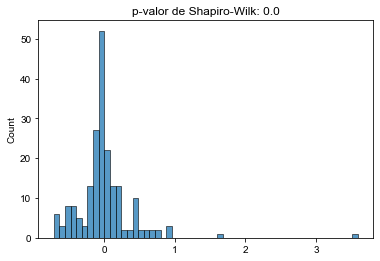

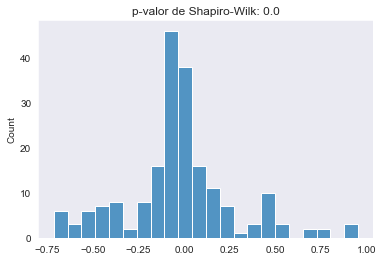

In [3]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

model2 = ols(f'exec_time ~ C(solver)', data=df).fit()
res2 = sm.stats.anova_lm(model2, typ=2)

pvalor = shapiro(model2.resid).pvalue
sns.histplot(model2.resid)
sns.set_style('dark')
plt.title(f'p-valor de Shapiro-Wilk: {round(pvalor, 5)}')
plt.savefig('../Plots/Residuals_plot.svg', bbox_inches = 'tight')
plt.show()

pvalor = shapiro(model2.resid[model2.resid < 1.5]).pvalue
sns.histplot(model2.resid[model2.resid < 1.5])
sns.set_style('dark')
plt.title(f'p-valor de Shapiro-Wilk: {round(pvalor, 5)}')
plt.savefig('../Plots/Residuals_plot_cortado.svg', bbox_inches = 'tight')
plt.show()

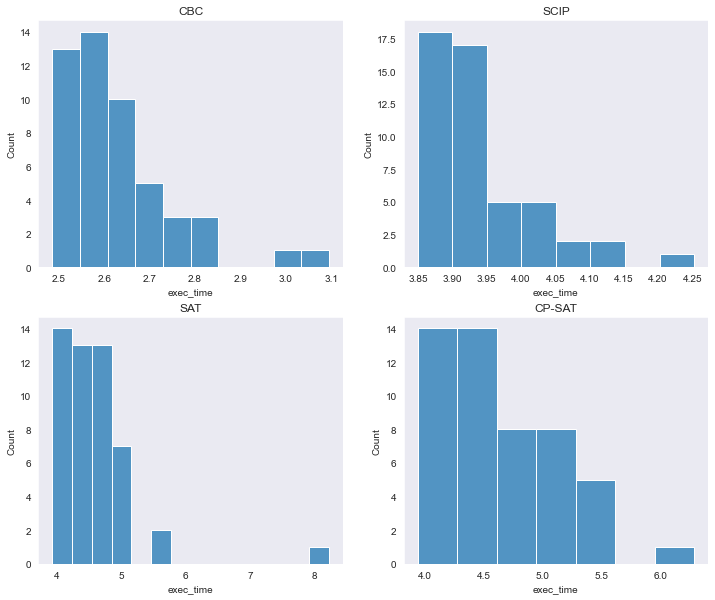

In [4]:
plt.figure(figsize=(12,10))
for i,s in enumerate(df['solver'].unique()):
    pvalor = shapiro(df[df['solver'] == s]['exec_time']).pvalue
    
    plt.subplot(2,2,i+1)
    plt.title(s)
    sns.histplot(data = df[df['solver'] == s], x = 'exec_time')
    sns.set_style('dark')
plt.savefig('../Plots/Distribuciones.svg', bbox_inches = 'tight')
plt.show()

No sería correcto utilizar un ANOVA ya que las poblaciones no cumplen la hipótesis de normalidad. Debido a esto, vamos a comparar los tiempos de ejecución de los distintos solvers utilizando el test de Kruskal-Wallis, el cual no asume normalidad ni homocedasticidad. Sin embargo, sí que asume que las distribuciones son similares, así como la independencia. Por la forma en la que han sido generadas las muestras se puede garantizar la independencia, y podemos observar en los histogramas de cada solver que la distribución es similar, por lo que podemos emplear el test de Kruskal-Wallis

### Test de Kruskal-Wallis

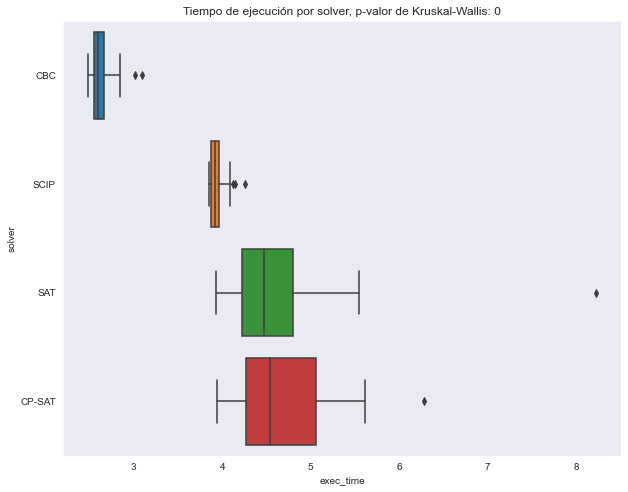

,CBC,CP-SAT,SAT,SCIP
CBC,1.000000e+00,2.543922e-27,6.132818e-26,5.212650e-06
CP-SAT,2.543922e-27,1.000000e+00,7.676555e-01,3.571621e-10
SAT,6.132818e-26,7.676555e-01,1.000000e+00,2.283440e-09
SCIP,5.212650e-06,3.571621e-10,2.283440e-09,1.000000e+00


In [7]:
from scipy.stats import kruskal
from scikit_posthocs import posthoc_dunn

test_k = kruskal(*res['exec_time'].values())

plt.figure(figsize = (10,8))
sns.boxplot(data = df, x = 'exec_time', y = 'solver')
sns.set_style('dark')
plt.title(f'Tiempo de ejecución por solver, p-valor de Kruskal-Wallis: {round(test_k.pvalue)}')
plt.savefig('../Plots/Boxplot.svg', bbox_inches = 'tight')
plt.show()

dunn = posthoc_dunn(df, val_col = 'exec_time', group_col = 'solver')
dunn

Como el p-valor es menor a 0.01 rechazamos la hipótesis nula, por lo que consideramos que existen diferencias significativas entre las poblaciones. Sin embargo, con este test no podemos saber qué solvers son significativamente más rápidos, por lo que también hemos realizado un test de Dunn entre cada par de solvers. Gracias a este hemos descubierto que el solver más rápido para nuestro problema es CBC. SCIP es significativamente más lento que CBC pero más rápido que SAT y CP-SAT, entre los que no existen diferencias significativas.

## Experimentación con el número de equipos

Para estudiar como se comporta cada solver para diferentes tallas del problema, vamos a generar un modelo para valores de entre 4 y 10 equipos para cada solver.
Como el número de partidos totales esta directamente relacionado con el número de equipos en la liga, debemos tener en cuenta que es conveniente también aumentar el numero de días ligueros en función del número de equipos, para ello hemos aumentado el valor inicial de 60 (para 4 equipos) con un factor de 
$10*(n\_equipos-4)$. 

Dado que desconocemos si estos solvers son deterministas, sería conveniente ejecutar cada prueba por solver y numero de equipos al menos 10 veces, sin embargo, dado que el coste temporal es muy elevado, tan sólo hemos realizado una ejecución por cada par de n_equipos y solver.

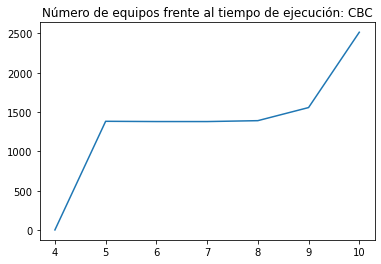

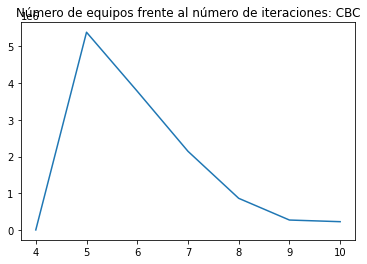

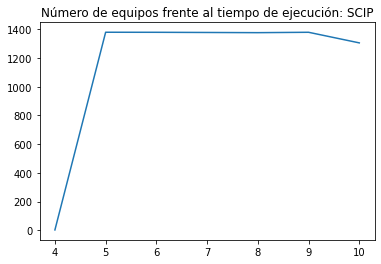

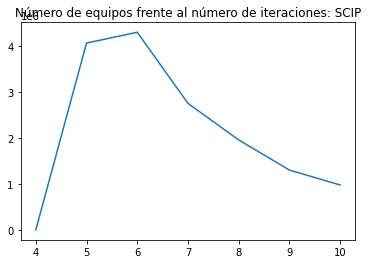

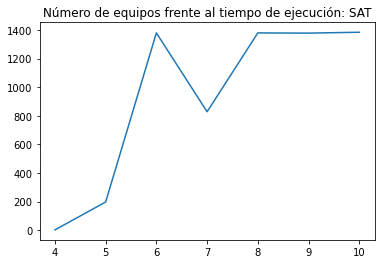

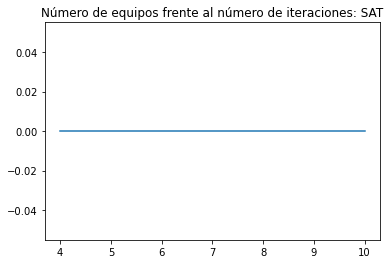

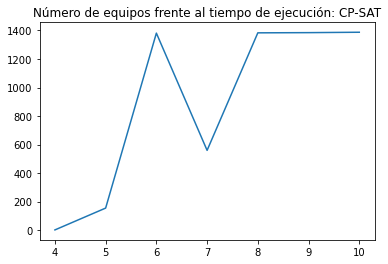

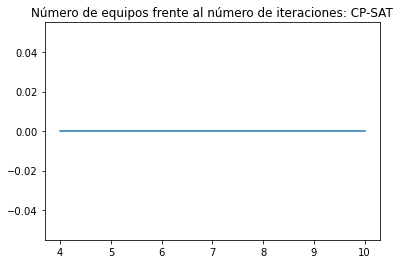

In [2]:
dfs = []
for j in ['CBC', 'SCIP', 'SAT', 'CP-SAT']:
    n_equipos, exec_time, n_iters, solvers, statuses = [], [], [], [], []
    for i in range(4,11):
        solver = pywraplp.Solver.CreateSolver(j)

        s, t = experimento(solver, i, 60 + 10*(i-4), 23 * 60)

        n_equipos.append(i)
        exec_time.append(t)
        n_iters.append(solver.Iterations())
        solvers.append(j)
        statuses.append(s)
#         print(n_equipos,exec_time)
    dfs.append(pd.DataFrame({'n_equipos': n_equipos, 'exec_time': exec_time, 'n_iters': n_iters, 'solver': solvers, 'statuses':statuses}))
        
    plt.figure()
    plt.title(f'Número de equipos frente al tiempo de ejecución: {j}')
    plt.plot(n_equipos, exec_time)
    plt.savefig('resultados_equipos/'+j+'_exec_time.png', bbox_inches='tight')
        
    plt.figure()
    plt.title(f'Número de equipos frente al número de iteraciones: {j}')
    plt.plot(n_equipos, n_iters)
    plt.savefig('resultados_equipos/'+j+'_n_iters.png', bbox_inches='tight')

pd.concat(dfs, ignore_index=True).to_csv('results_nEquipos.csv', sep= ',', encoding='utf-8', index=False)

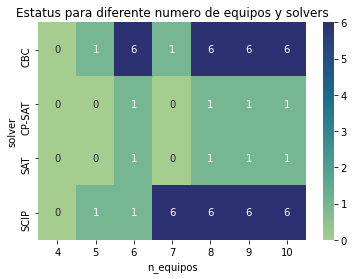

In [5]:
df = pd.read_csv('resultados_equipos/results_nEquipos.csv', sep=',')
data_for_heatmap=df[['n_equipos','solver','statuses']]
data_for_heatmap = data_for_heatmap.pivot('solver','n_equipos','statuses')
ax = sns.heatmap(data_for_heatmap, cmap='crest', annot=True)
ax.set_title('Estatus para diferente numero de equipos y solvers')
ax.plot()
plt.savefig('resultados_equipos/N_equipos_vs_solver.png', bbox_inches='tight')

Podemos ver como, SAT y CP-SAT obtienen soluciones para los modelos con 7+ equipos, mientras que CBC y SCIP no. Es curioso ya que como veremos a continuación, CBC es el solver mas rápido en los experimentos con 4 equipos, sin embargo, con un mayor número de equipos, vemos que este solver no utiliza todo el tiempo disponible (23 minutos) y no encuentra solución, mientras que SAT y CP-SAT son mas lentos en el experimento con 4 equipos, obtenemos que para un mayor número de equipos estos emplean todo el tiempo disponible y encuentran solución factible para todos ellos.